<a href="https://colab.research.google.com/github/nalrob/Datos_Masivos_MCD/blob/main/Proyecto_Final_3tet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')


import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
import spacy

# 1. Transformación de Datos

*Source 1*

In [6]:
true_df_source1 = pd.read_csv('/content/True_1.csv')
false_df_source1 = pd.read_csv('/content/Fake_1.csv')

In [7]:
true_df_source1['class'] = 1
false_df_source1['class'] = 0

*Source 2*

In [8]:
tf_df_source3= pd.read_csv('/content/fake_or_real_news.csv')
tf_df_source3.rename(columns={'label': 'class'}, inplace=True)
tf_df_source3['class'] = tf_df_source3['class'].replace({'FAKE': 0, 'REAL': 1})
tf_df_source3.head(5)

,Unnamed: 0,title,text,class
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


*Source 3*

In [9]:
tf_df_source4=pd.read_csv('/content/news_articles.csv')
tf_df_source4.rename(columns={'published': 'date'}, inplace=True)
tf_df_source4.rename(columns={'label': 'class'}, inplace=True)
tf_df_source4['class'] = tf_df_source3['class'].replace({'Fake': 0, 'Real': 1})
tf_df_source4.head(5)

,author,date,title,text,language,site_url,main_img_url,type,class,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,0,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,1,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,0,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,1,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [10]:
#Dataset sin transformación
news_df = pd.concat([true_df_source1,false_df_source1,tf_df_source3,tf_df_source4])
news_df = news_df[['title', 'text', 'subject', 'date','class']]
news_df.head(5)

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
len(news_df)

53329

In [73]:
#Dataset sin transformación
news_df = news_df.dropna(subset=['date'])
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce',utc=True)

null_dates = news_df['date'].isnull().sum()
if null_dates > 0:
    print(f"Advertencia: Se encontraron {null_dates} valores nulos o incorrectos en la columna 'date'")


news_df['date'] = news_df['date'].dt.strftime('%d/%m/%Y')
news_df.head(5)

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31/12/2017,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29/12/2017,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31/12/2017,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30/12/2017,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29/12/2017,1


In [74]:
#Eliminación de datos nulos

news = news_df.dropna(subset=['text'])
news['text'].isnull().sum()

0

In [75]:
#Dataset transformado

news['text']= news['title'] + " " + news['text']
del news['title']
del news['date']
del news['subject']
news.head()

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [76]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46936 entries, 0 to 2049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    46936 non-null  object
 1   class   46936 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


# 2. Muestreo

### Muestreo estratificado

In [77]:
from sklearn.utils import resample

# Suponiendo que 'class' es la columna que deseas utilizar para el muestreo estratificado
# En este caso, 'class' debe ser una columna que represente las etiquetas de tus datos

# Dividir el dataframe en dos: uno con las características (X) y otro con la variable objetivo (y)
X = news.drop('class', axis=1)
y = news['class']

# Realizar el muestreo estratificado
X_resampled, y_resampled = resample(X, y,
                                    stratify=y,  # Remuestreo estratificado según las etiquetas
                                    n_samples=2000,  # Tamaño de la nueva muestra
                                    random_state=42)  # Semilla aleatoria para reproducibilidad


In [78]:
X_resampled, y_resampled = resample(X, y)

In [79]:
news_resampled = resample(news, replace=True, n_samples=2000, random_state=42)

In [80]:
len(news_resampled)

2000

In [81]:
news_resampled.head()

,text,class
15795,U.N. refugee commissioner says Australia must ...,1
860,Republican tax plan would deal financial hit t...,1
16746,"HOW 125,000 ILLEGAL KIDS Have Been Able To Avo...",0
23325,Boiler Room #61 – Hello From the Gutter Tune i...,0
11284,Nigeria says U.S. agrees delayed $593 million ...,1


# 3. Preprocesamiento

Normalización paralelizada con Dask

In [82]:
import dask.bag as db
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")


def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def remove_punctuations(text):
    return re.sub(r"\[[^]]*\]", "", text)


def remove_characters(text):
    return re.sub(r"[^a-zA-Z]", " ", text)


def remove_stopwords_and_lemmatization(text):
    text = text.lower()
    words = word_tokenize(text)
    lemma = WordNetLemmatizer()
    final_text = [lemma.lemmatize(word) for word in words if word not in set(stopwords.words("english"))]
    return " ".join(final_text)


def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text


def parallel_cleaning(texts):
    bag = db.from_sequence(texts)
    cleaned_texts = bag.map(cleaning).compute()
    return list(cleaned_texts)


# Asignar los textos limpios a la columna 'text' del DataFrame 'news_resampled'
news_resampled['text'] = parallel_cleaning(news_resampled['text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 4. Evaluación de Polaridad

In [203]:
from textblob import TextBlob

news['text'] = news['text'].astype(str)

def get_text_polarity(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

news['polarity'] = news['text'].apply(get_text_polarity)

print(news.head())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

         date  class  
0  31/12/2017      1  
1  29/12/2017      1  
2  31/12/2017      1  
3  30/12/2017      1  
4  29/12/2017      1  


# 5. Visualización de datos

Datos preprocesados

In [172]:
import plotly.graph_objects as go
values = news_resampled['class'].value_counts() / news_resampled['class'].shape[0]
labels = ['Fake News', 'Real News']
colors = ['gold', 'mediumturquoise']


fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])

fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title_text="Target Balance",
    title_font_color="black",
    legend_title_font_color="yellow",
    paper_bgcolor="white",
    plot_bgcolor='black',
    font_color="black",
)

fig.show()


Evaluación de Polaridad de ambas clases

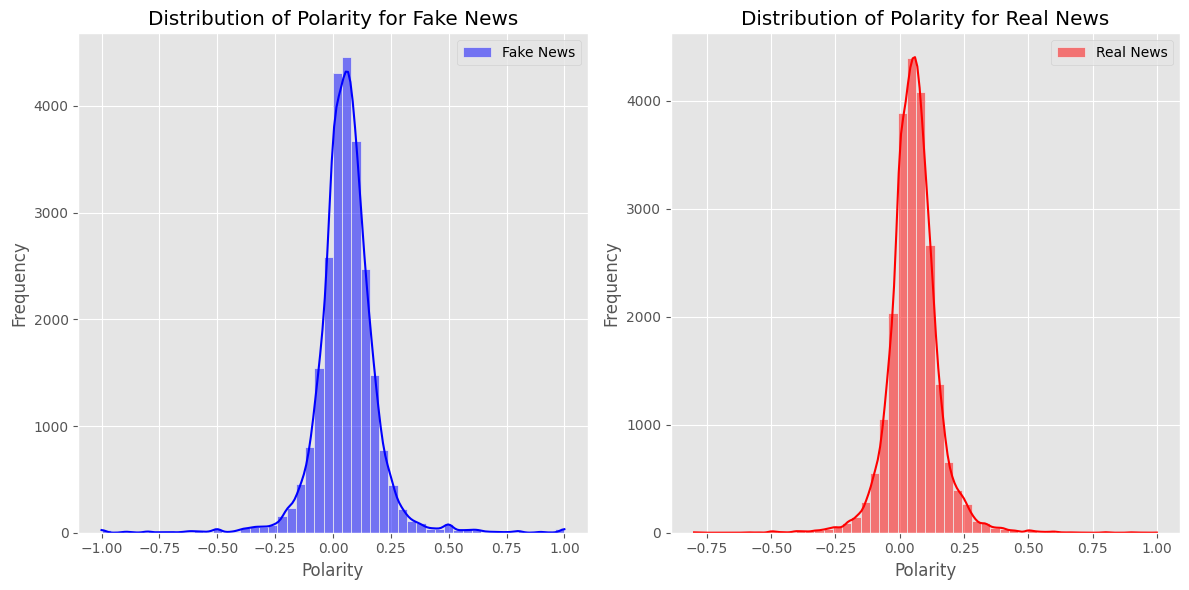

In [204]:
# Filtrar el dataframe por clase
class_0_df = news[news['class'] == 0]
class_1_df = news[news['class'] == 1]

# Calcular las polaridades para cada clase
class_0_polarities = class_0_df['polarity']
class_1_polarities = class_1_df['polarity']

# Crear dos gráficos usando sns.histplot
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura a 12x6 pulgadas

plt.subplot(1, 2, 1)  # Gráfico 1: Fake News
sns.histplot(class_0_polarities, bins=50, color='blue', label='Fake News', kde=True)
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Polarity for Fake News')
plt.legend()

plt.subplot(1, 2, 2)  # Gráfico 2: Real News
sns.histplot(class_1_polarities, bins=50, color='red', label='Real News', kde=True)
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Polarity for Real News')
plt.legend()

plt.tight_layout()  # Ajustar el espaciado entre subplots
plt.show()


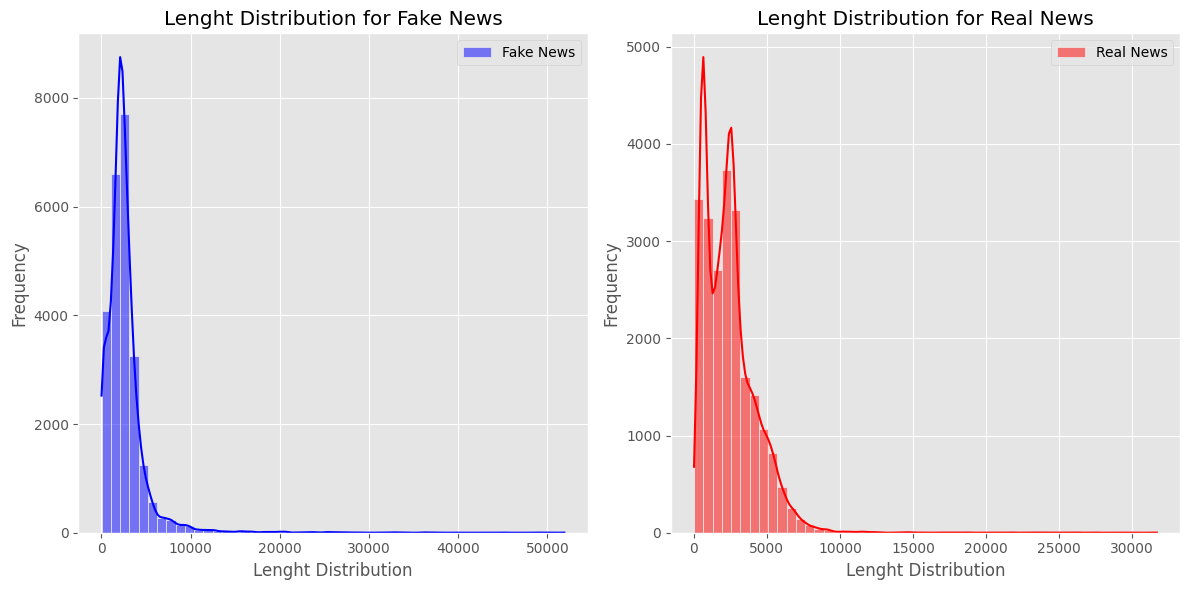

In [176]:
# Calcular el largo de la variable 'text' en cada fila
news_resampled['text_length'] = news['text'].apply(len)

# Filtrar el dataset para obtener solo la clase 0 (Fake News) y la clase 1 (Real News)
class_0_data = news[news['class'] == 0]['text_length']
class_1_data = news[news['class'] == 1]['text_length']


# Crear dos gráficos usando sns.histplot
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura a 12x6 pulgadas

plt.subplot(1, 2, 1)  # Gráfico 1: Fake News
sns.histplot(class_0_data, bins=50, color='blue', label='Fake News', kde=True)
plt.xlabel('Lenght Distribution')
plt.ylabel('Frequency')
plt.title('Lenght Distribution for Fake News')
plt.legend()

plt.subplot(1, 2, 2)  # Gráfico 2: Real News
sns.histplot(class_1_data, bins=50, color='red', label='Real News', kde=True)
plt.xlabel('Lenght Distribution')
plt.ylabel('Frequency')
plt.title('Lenght Distribution for Real News')
plt.legend()

plt.tight_layout()  # Ajustar el espaciado entre subplots
plt.show()

Wordcloud para Fake News

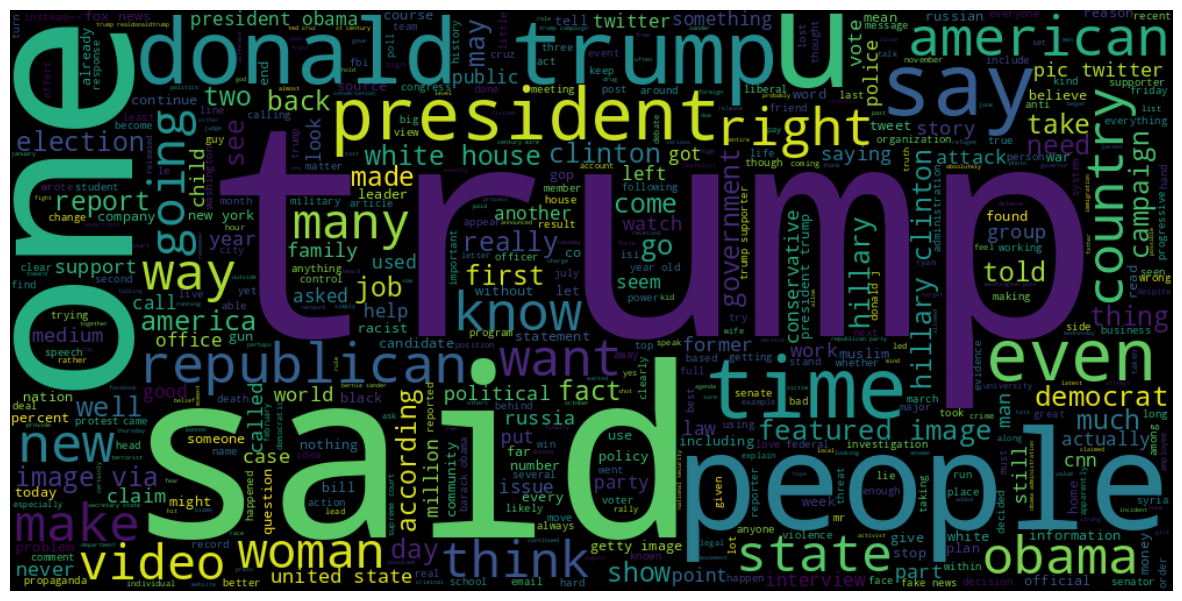

In [205]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
wc = WordCloud(max_words=500, width=1000, height=500, stopwords=STOPWORDS).generate(" ".join(news_resampled[news_resampled['class'] == 0]['text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  # Para ocultar los ejes del gráfico
plt.show()


Wordcloud para Real News

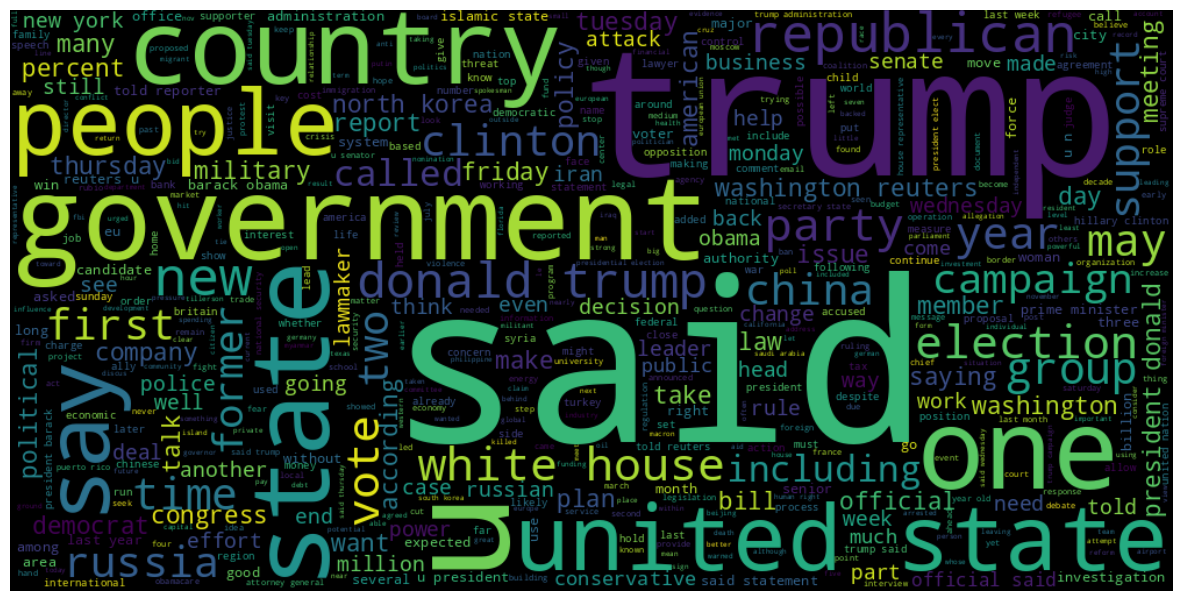

In [206]:
plt.figure(figsize=(15, 15))
wc = WordCloud(max_words=500, width=1000, height=500, stopwords=STOPWORDS).generate(" ".join(news_resampled[news_resampled['class'] == 1]['text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  # Para ocultar los ejes del gráfico
plt.show()


N-Gram Analysis

In [207]:
texts_pros = ' '.join(news_resampled['text'])
string = texts_pros.split(" ")

In [208]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

           word  count
0      (trump,)   6626
1       (said,)   5541
2          (u,)   3369
3  (president,)   2671
4      (state,)   2641


<Axes: xlabel='count', ylabel='word'>

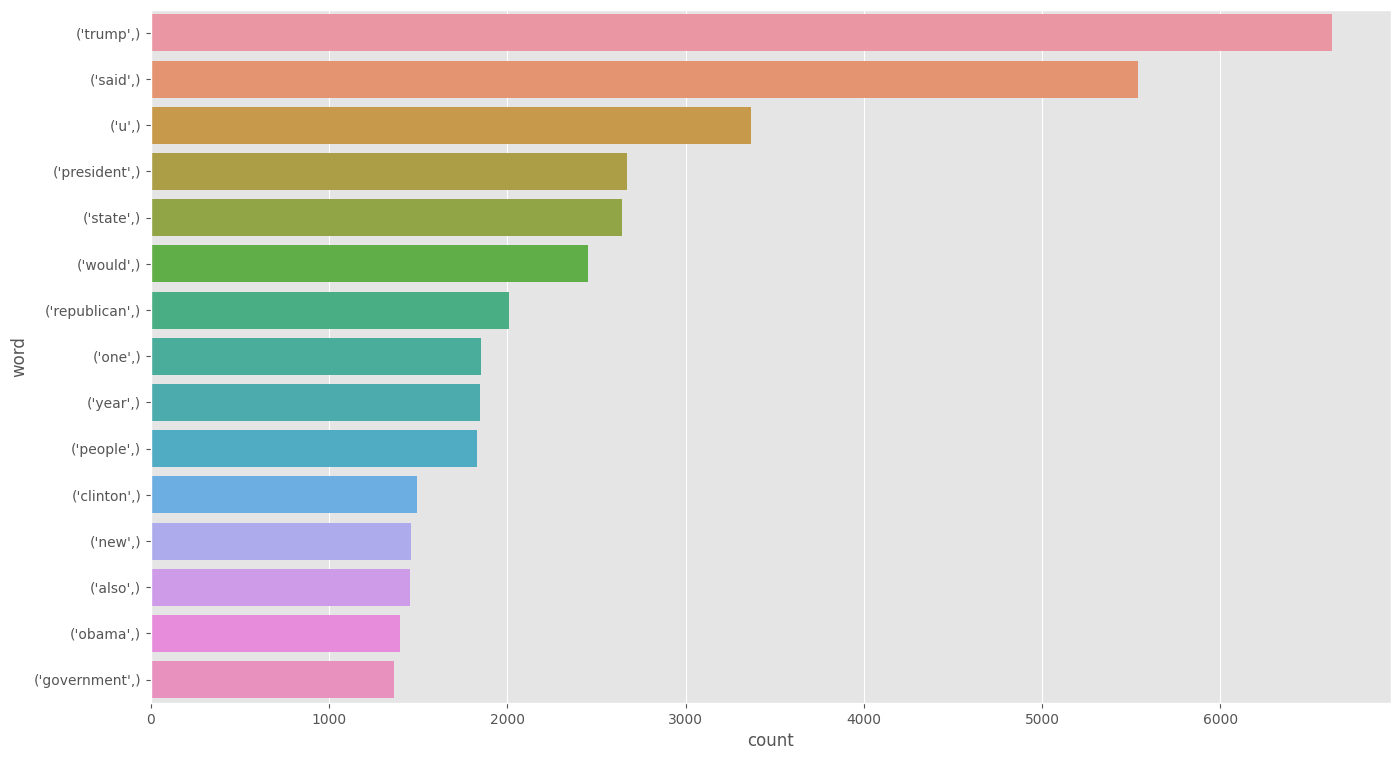

In [210]:
#Unigram Analysis
draw_n_gram(string,1)

                         word  count
0      (featured, image, via)    288
1  (president, donald, trump)    287
2         (pic, twitter, com)    276
3  (president, barack, obama)    167
4          (donald, j, trump)    107


<Axes: xlabel='count', ylabel='word'>

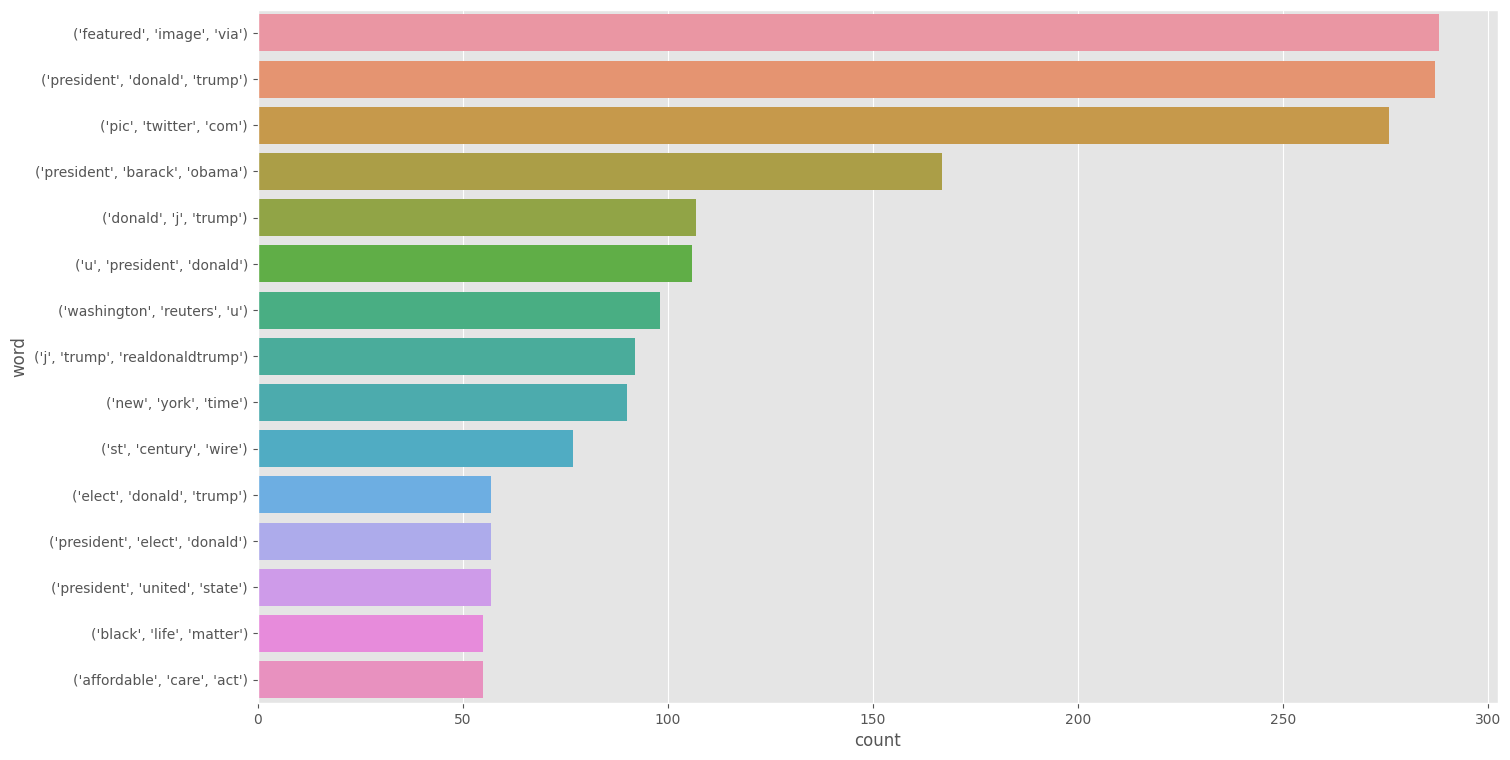

In [209]:
#Trigram Analysis
draw_n_gram(string,3)

# 5. Red Neuronal LSTM

Model Training

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(news_resampled['text'], news_resampled['class'], random_state=0)

In [84]:
features = news_resampled['text']
targets = news_resampled['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [86]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [87]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Arquitectura del modelo

In [88]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [89]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

auc_callback = AUC()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', auc_callback])

# Entrena el modelo y guarda el historial
history = model.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/5
48/48 [==============================] - 20s 272ms/step - loss: 0.6924 - accuracy: 0.5083 - auc_2: 0.5295 - val_loss: 0.6909 - val_accuracy: 0.5500 - val_auc_2: 0.5221
Epoch 2/5
48/48 [==============================] - 10s 205ms/step - loss: 0.6882 - accuracy: 0.5083 - auc_2: 0.6519 - val_loss: 0.6826 - val_accuracy: 0.5500 - val_auc_2: 0.9224
Epoch 3/5
48/48 [==============================] - 9s 192ms/step - loss: 0.6512 - accuracy: 0.5194 - auc_2: 0.8936 - val_loss: 0.5841 - val_accuracy: 0.6438 - val_auc_2: 0.9222
Epoch 4/5
48/48 [==============================] - 8s 173ms/step - loss: 0.4454 - accuracy: 0.8556 - auc_2: 0.9244 - val_loss: 0.3452 - val_accuracy: 0.9062 - val_auc_2: 0.9215
Epoch 5/5
48/48 [==============================] - 8s 164ms/step - loss: 0.2634 - accuracy: 0.9410 - auc_2: 0.9543 - val_loss: 0.2717 - val_accuracy: 0.9250 - val_auc_2: 0.9258


In [90]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "Epoch", 'y': "Loss"},
    title="Loss Over Time"
)

fig.show()

In [91]:
fig = px.line(
    history.history,
    y=['accuracy', 'auc_2'],
    labels={'x': "Epoch", 'y': "AUC"},
    title="AUC Over Time"
)

fig.show()

In [92]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 25ms/step - loss: 0.2499 - accuracy: 0.9300 - auc_2: 0.9491


[0.2498605102300644, 0.9300000071525574, 0.9491475820541382]

13/13 [==============================] - 2s 20ms/step


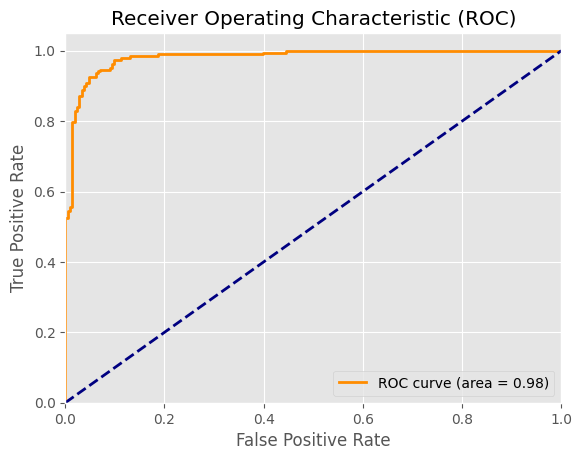

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las probabilidades de la clase positiva (1) del modelo
y_pred_prob = model.predict(X_test)

# Calcular la tasa de falsos positivos (FPR) y la tasa de verdaderos positivos (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


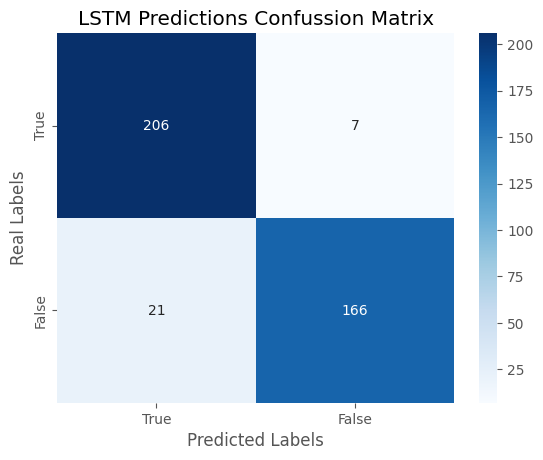

In [95]:
from sklearn.metrics import confusion_matrix

umbral = 0.5
y_pred_binario = (y_pred_prob > umbral).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binario)

TN, FP, FN, TP = conf_matrix.ravel()
labels = ['True', 'False']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('LSTM Predictions Confussion Matrix')

plt.show()

# 6. Red Neuronal GRU

Preprocesamiento

In [50]:
texts= news_resampled['text']
labels = np.array(news_resampled['class'])

In [51]:
# Get size of vocabulary
vocabulary = set()

for text in texts:
    for word in text:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max length of a sequence
max_seq_length = 0

for text in texts:
    if len(text) > max_seq_length:
        max_seq_length = len(text)

# Print results
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 27
Max sequence length: 25123


In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_seq_length)

In [53]:
model_inputs

array([[ 0,  0,  0, ..., 23, 12, 23],
       [ 0,  0,  0, ..., 15, 10,  2],
       [ 0,  0,  0, ..., 13,  5,  2],
       ...,
       [ 0,  0,  0, ..., 10, 23, 24],
       [ 0,  0,  0, ...,  6, 22, 10],
       [ 0,  0,  0, ...,  2, 10, 24]], dtype=int32)

In [54]:
model_inputs.shape

(2000, 25123)

Model Training

In [55]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels)

Arquitectura del modelo

In [56]:
embedding_dim = 64


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(gru)


model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


batch_size = 32
epochs = 5

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
        tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)
    ]
)

Epoch 1/5
38/38 [==============================] - 29s 672ms/step - loss: 0.6259 - accuracy: 0.6775 - auc: 0.7780 - val_loss: 0.5689 - val_accuracy: 0.7167 - val_auc: 0.8312 - lr: 0.0010
Epoch 2/5
38/38 [==============================] - 25s 655ms/step - loss: 0.4017 - accuracy: 0.8300 - auc: 0.9011 - val_loss: 0.4232 - val_accuracy: 0.8467 - val_auc: 0.9003 - lr: 0.0010
Epoch 3/5
38/38 [==============================] - 28s 749ms/step - loss: 0.2968 - accuracy: 0.8933 - auc: 0.9436 - val_loss: 0.3556 - val_accuracy: 0.8967 - val_auc: 0.9243 - lr: 0.0010
Epoch 4/5
38/38 [==============================] - 25s 658ms/step - loss: 0.2086 - accuracy: 0.9417 - auc: 0.9617 - val_loss: 0.1993 - val_accuracy: 0.9500 - val_auc: 0.9552 - lr: 0.0010
Epoch 5/5
38/38 [==============================] - 30s 781ms/step - loss: 0.1568 - accuracy: 0.9633 - auc: 0.9678 - val_loss: 0.1871 - val_accuracy: 0.9567 - val_auc: 0.9584 - lr: 0.0010


In [57]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'x': "Epoch", 'y': "Loss"},
    title="Loss Over Time"
)

fig.show()

In [58]:
fig = px.line(
    history.history,
    y=['auc', 'val_auc'],
    labels={'x': "Epoch", 'y': "AUC"},
    title="AUC Over Time"
)

fig.show()

In [59]:
model.load_weights('./model.h5')

In [60]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 5s 284ms/step - loss: 0.1261 - accuracy: 0.9680 - auc: 0.9801


[0.1261100023984909, 0.9679999947547913, 0.9801376461982727]

16/16 [==============================] - 4s 238ms/step


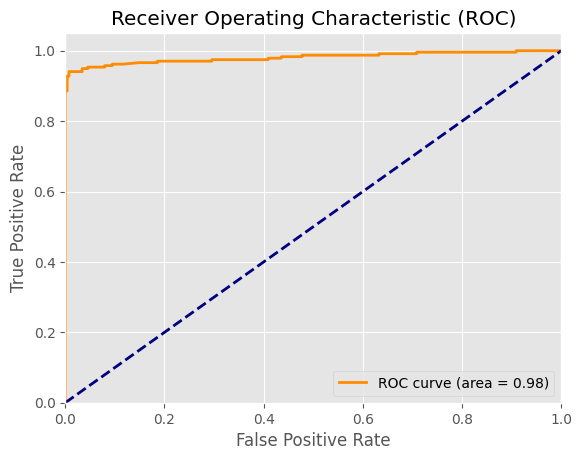

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las probabilidades de la clase positiva (1) del modelo
y_pred_prob = model.predict(X_test)

# Calcular la tasa de falsos positivos (FPR) y la tasa de verdaderos positivos (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


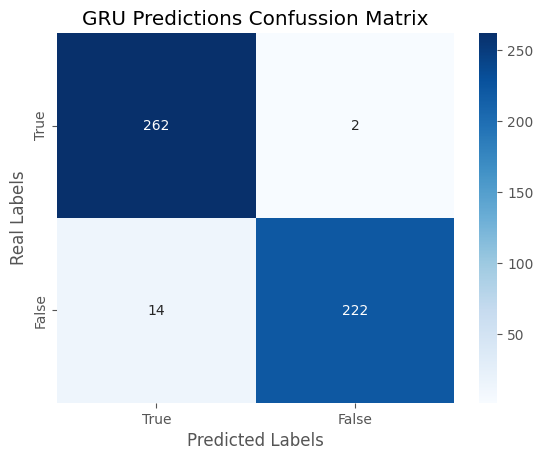

In [63]:
from sklearn.metrics import confusion_matrix

umbral = 0.5
y_pred_binario = (y_pred_prob > umbral).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binario)

TN, FP, FN, TP = conf_matrix.ravel()
labels = ['True', 'False']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('GRU Predictions Confussion Matrix')

plt.show()